## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#Read CSV file
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# Total rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
#Unique rows
len(df['user_id'].unique())

290584

d. The proportion of users converted.

In [5]:
# The proportion of users converted
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# The number of times the new_page and treatment don't match.

x=df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")')['user_id'].count()
x

3893

f. Do any of the rows have missing values?

In [7]:
#fNumber of missing data.
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

__No missing data__


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# adding where treatment does not match with new_page or control does not match with old_page to NEW dataset
df2=df.query('(group=="treatment" & landing_page=="new_page") or (group=="control" & landing_page=="old_page")')
#number of rows
len(df2)

290585

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [9]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [10]:
## check for duplicated user_id
len(df2[df2.duplicated(['user_id'], keep=False)]['user_id'])

2

c. What is the row information for the repeat **user_id**? 

In [11]:
# quick look at duplicated rows
df2[df2.duplicated(['user_id'],keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2=df2.drop_duplicates(['user_id'],keep='first')


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [13]:
# propotion of user converted 
df2['converted'].mean()


0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
converted_control=df2.query('group=="control"')['converted'].mean()
converted_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
converted_treatment=df2.query('group=="treatment"')['converted'].mean()
converted_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [16]:
len(df2.query('landing_page=="new_page"'))/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

#### Control group =12.03%
#### treatment group (11.88%)
####  but this diffrence  can not indicate  that old_page is better than new_page. it might some people who did not received new page willing to convert new page


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Based in our PART one A/B test we assume 
                                            
                                            H0: p_old>= p_new
                                            H1: p_old< p_new


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [17]:
pnew=df2['converted'].mean()
pnew


0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [18]:
pold=df2['converted'].mean()
pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [19]:
nnew=df2[df2['group']=='treatment'].shape[0]
nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [20]:
nold=df2.query('group=="control"').shape[0]
nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
#the new_page_converted
new_page_converted=np.random.binomial(1,p=pnew,size=nnew)
new_page_converted

array([0, 0, 0, ..., 1, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [22]:
#the old_page_converted
old_page_converted=np.random.binomial(1,p=pold,size=nold)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [23]:
diff=new_page_converted.mean()-old_page_converted.mean()
diff

0.002310695743824809

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [24]:
new=np.random.binomial(nnew,p=pnew,size=1000)/nnew
old=np.random.binomial(nold,p=pold,size=1000)/nold
p_diffs=new-old
p_diffs

array([ 1.07842878e-03,  7.34389703e-04, -1.81009121e-04,  1.01390139e-04,
        2.93678107e-03,  2.25532554e-03, -7.77440206e-05,  5.20800304e-04,
        1.55354852e-03, -1.27522320e-03,  1.94566667e-03, -3.10592535e-03,
        2.54085255e-05,  1.04367339e-03,  5.27794697e-04,  1.63135687e-04,
        2.45647832e-04,  2.18067611e-04,  3.28301524e-04,  2.54835618e-05,
        8.23974689e-04, -8.35060080e-04,  1.18873943e-03, -3.04786719e-04,
       -5.93960380e-04, -4.90841941e-04, -6.83608465e-04, -1.18590766e-03,
        8.78884443e-04,  3.01260920e-03,  2.73383243e-04, -8.07585591e-04,
       -1.72263140e-03, -3.20254224e-03,  7.76032042e-04, -1.35099335e-03,
        6.03803597e-04,  1.13400533e-03,  3.83299957e-04,  8.37453569e-04,
        8.51500339e-04,  2.69587748e-03, -1.66085686e-03,  3.55689039e-04,
       -3.39241958e-04, -3.18625433e-04, -9.45118340e-04, -2.43863426e-03,
        7.35541113e-05,  1.18866610e-03,  5.07070734e-04,  1.04408609e-03,
       -2.91120248e-04, -

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

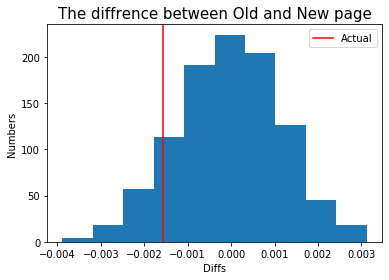

In [25]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs);
plt.title('The diffrence between Old and New page',fontsize=15)
plt.xlabel('Diffs')
plt.ylabel('Numbers')
actual=converted_treatment-converted_control
plt.axvline((actual),color='red',label='Actual')
plt.legend();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [26]:
p_diffs_mean=(actual<p_diffs).mean()
def_mean

NameError: name 'def_mean' is not defined

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

 1. diffs_mean is called __p-value__
 2. since p-value is high then hypothesis is fail to reject.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [ ]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page" and converted==1').shape[0]
convert_new = df2.query('landing_page=="new_page" and converted==1').shape[0]
nold = df2.query('landing_page=="old_page"').shape[0]
nnew = df2.query('landing_page=="new_page"').shape[0]

print("convert_old is", convert_old)
print("convert_new is", convert_new)
print("number of old page is", nold)
print("number of new page is", nnew)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [ ]:
z_score,p_value=sm.stats.proportions_ztest([convert_old,convert_new],[nold,nold],alternative='smaller')
print("Z_Score is",z_score)
print("P_Value is",p_value)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

The better type of regression is __Logitic Regression__ 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [ ]:
df2['intercept']=1
# creat dummey variable for sake of logit function
df2[['control','treatment']]=pd.get_dummies(ab2['group'])
#intercept and dummey variables
ab2.head()

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [ ]:
logit=sm.Logit(df2['converted'],df2[['intercept','treatment']])
result=logit.fit()


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [ ]:
result.summary()

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

#### p-value = 0.190
#### And it is different than PART 2 p-value since we have two side test rather one side as before.
#### Anyway p-value > 0.5 then we have fail to reject null hypothesis

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### The dataset is limited since we do not have more information why they are not converted .we might take better decision if we Accured some information as below:
* Gender
* Age
* Location
* channel(mobile or PC)

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [ ]:
country=pd.read_csv('countries.csv')
country.head()

In [ ]:
# adding counrty to our dataset using join by user_id
df3=country.set_index('user_id').join(df2.set_index('user_id'),how='inner')
ab3.head()

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
df3['intercept']=1
df3[['CA','US']]=pd.get_dummies(df3['country'])[['CA','US']]
df3.head()

In [ ]:
logit2=sm.Logit(df3['converted'],df3[['intercept','CA','US']])
result2=logit2.fit()
result2.summary()